# Dataset:
Biće korišćen MNIST dataset.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
(train_images, _), (test_images, _) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [ ]:
print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [ ]:
def plot_images(original, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for i in range(n,2*n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

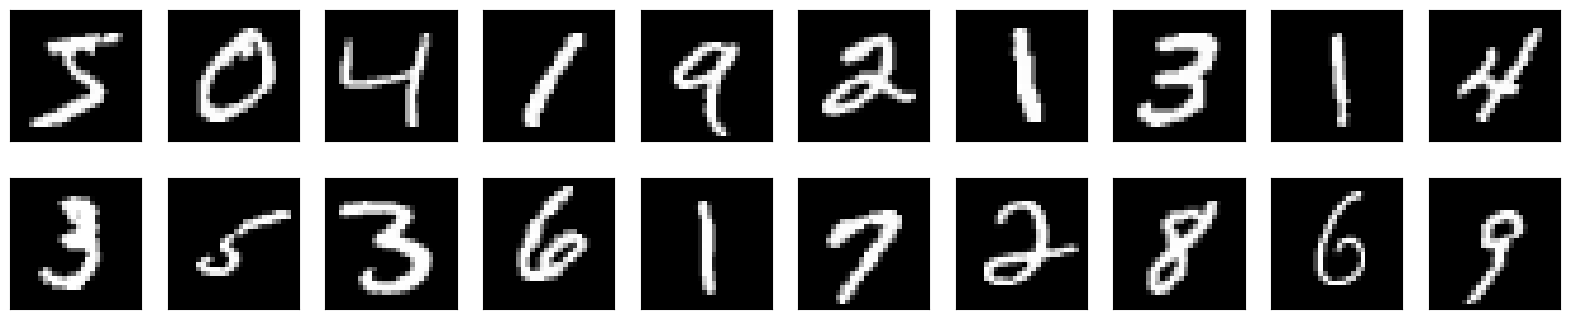

In [ ]:
plot_images(train_images)

In [ ]:
import tensorflow as tf
def linear_beta(t, start = 0.0001, end = 0.02):
  return tf.linspace(start, end, t)


In [ ]:
def get_index_from_list(vals, t):

    batch_size = tf.shape(t)[0]
    out = tf.gather(vals, t)
    return tf.reshape(out, [batch_size] + [1] * (len(vals.shape) - 1))


In [ ]:
T = 300
betas = linear_beta(T)
alphas = 1.0-betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = tf.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.sqrt(1.0 - alphas_cumprod)
alphas_cumprod_prev = tf.concat([tf.constant([1.0], dtype=tf.float32), alphas_cumprod[:-1]], axis=0)
sqrt_recip_alphas = tf.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    noise = tf.random.normal(shape=tf.shape(x_0))
    sqrt_alphas_cumprod_t = tf.gather(sqrt_alphas_cumprod, t)
    sqrt_one_minus_alphas_cumprod_t = tf.gather(sqrt_one_minus_alphas_cumprod, t)
    sqrt_alphas_cumprod_t_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(sqrt_alphas_cumprod_t, axis=-1), axis=-1), axis=-1)
    sqrt_one_minus_alphas_cumprod_t_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(sqrt_one_minus_alphas_cumprod_t, axis=-1), axis=-1), axis=-1)

    x_t = sqrt_alphas_cumprod_t_expanded * x_0 + sqrt_one_minus_alphas_cumprod_t_expanded * noise
    return x_t, noise



In [ ]:
from tensorflow.data import Dataset
BATCH_SIZE = 512
def transformed_dataset(train_images, test_images):

  def preprocess(image):
    image = (image * 2) - 1
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    return image

  train_dataset = Dataset.from_tensor_slices(train_images)#pravi DATASET objekat
  train_dataset = train_dataset.shuffle(10000)#miksuje slike u okviru betcha
  train_dataset = train_dataset.map(preprocess)#koristi preprocesiranje-mozda dodati flip za sad ne
  train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)#deli na betcheve

  test_dataset = Dataset.from_tensor_slices(test_images)
  test_dataset = test_dataset.map(preprocess)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return train_dataset, test_dataset

In [ ]:
train_dataset, test_dataset = transformed_dataset(train_images, test_images)

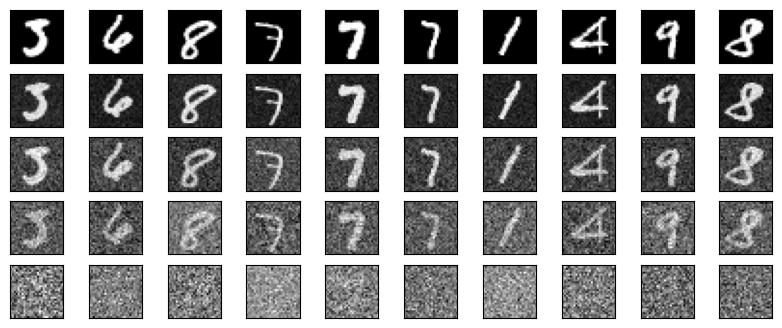

In [ ]:
k = 1;
for images in train_dataset:
  #images je ovde jedan betch od 512 slika!!!
    timesteps = tf.range(20)
    diffused_images1, _ = forward_diffusion_sample(images, 19, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    diffused_images2, _ = forward_diffusion_sample(images, 49, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    diffused_images3, _ = forward_diffusion_sample(images, 99, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    diffused_images4, _ = forward_diffusion_sample(images, 299, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)


    plt.figure(figsize=(10, 4))
    for i in range(10):


        ax = plt.subplot(5, 10, i + 1)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, 10, i + 11)
        plt.imshow(diffused_images1[i].numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, 10, i + 21)
        plt.imshow(diffused_images2[i].numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, 10, i + 31)
        plt.imshow(diffused_images3[i].numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, 10, i + 41)
        plt.imshow(diffused_images4[i].numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    break


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Input, concatenate, MaxPool2D
from tensorflow.keras import Model

class Block(Layer):
    def __init__(self, in_ch, out_ch, up=False):
        super(Block, self).__init__()
        self.up = up
        if up:
            self.conv1 = Conv2D(out_ch, 3, padding='same')
            self.transform = Conv2DTranspose(out_ch, 3, strides=2, padding='same')
        else:
            self.conv1 = Conv2D(out_ch, 3, padding='same')
            self.transform = MaxPool2D((2, 2))
        self.conv2 = Conv2D(out_ch, 3, padding='same')
        self.bnorm1 = BatchNormalization()
        self.bnorm2 = BatchNormalization()
        self.relu = ReLU()

    def call(self, x):
        h = self.bnorm1(self.relu(self.conv1(x)))
        h = self.bnorm2(self.relu(self.conv2(h)))
        if self.up:
            h = self.transform(h)
        else:
            h = self.transform(h)
        return h

class SimpleUnet(Model):
    def __init__(self, input_shape=(BATCH_SIZE, 28, 28, 1)):
        super(SimpleUnet, self).__init__()
        self.input_layer = Input(shape=input_shape)
        image_channels = 1
        down_channels = [64, 128, 256]
        up_channels = [256, 128, 64]
        out_dim = 1

        # Initial projection
        self.conv0 = Conv2D(down_channels[0], 3, padding='same')

        # Downsample
        self.downs = [Block(down_channels[i], down_channels[i + 1]) for i in range(len(down_channels) - 1)]

        # Upsample
        self.ups = [Block(up_channels[i], up_channels[i + 1], up=True) for i in range(len(up_channels) - 1)]

        # Output layer
        self.output_layer = Conv2D(out_dim, 1)

    def call(self, x):
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = concatenate([x, residual_x], axis=-1)
            x = up(x)
        return self.output_layer(x)



In [ ]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noise_pred = model(x_noisy)
    return tf.reduce_mean(tf.abs(noise - noise_pred))


In [ ]:
IMG_SIZE = 28;
EPOCHS = 100;
model = SimpleUnet()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=get_loss)

In [ ]:
input_shape = (BATCH_SIZE, 28, 28, 1);
model.build(input_shape);
model.summary();

Model: "simple_unet_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  640       
                                                                 
 block_8 (Block)             multiple                  222464    
                                                                 
 block_9 (Block)             multiple                  887296    
                                                                 
 block_10 (Block)            multiple                  886144    
                                                                 
 block_11 (Block)            multiple                  221888    
                                                                 
 conv2d_29 (Conv2D)          multiple                  65        
                                                                 
Total params: 2218497 (8.46 MB)
Trainable params: 221

In [ ]:
def sample_timestep(x_0, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, betas, sqrt_recip_alphas, posterior_variance):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image. Applies noise to this image if we are not in the last step.
    """
    i = np.random.randint(0, 512)
    x_t, _ = forward_diffusion_sample(x_0, T-1, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noise_pred = model(x_t)


    plt.figure(figsize=(10, 4))

    for t in range(T-1, -1, -1):
        noise_pred = model(x_t)

        betas_t = tf.gather(betas, t)
        sqrt_recip_alphas_t = tf.gather(sqrt_recip_alphas, t)
        sqrt_one_minus_alphas_cumprod_t = tf.gather(sqrt_one_minus_alphas_cumprod, t)
        posterior_variance_t = tf.gather(posterior_variance, t)

        betas_t_e = tf.expand_dims(tf.expand_dims(tf.expand_dims(betas_t, axis=-1), axis=-1), axis=-1)
        sqrt_recip_alphas_t_e = tf.expand_dims(tf.expand_dims(tf.expand_dims(sqrt_recip_alphas_t, axis=-1), axis=-1), axis=-1)
        sqrt_one_minus_alphas_cumprod_t_e = tf.expand_dims(tf.expand_dims(tf.expand_dims(sqrt_one_minus_alphas_cumprod_t, axis=-1), axis=-1), axis=-1)
        posterior_variance_t_e = tf.expand_dims(tf.expand_dims(tf.expand_dims(posterior_variance_t, axis=-1), axis=-1), axis=-1)


        x_t_1 = sqrt_recip_alphas_t_e * (x_t - betas_t_e * noise_pred / sqrt_one_minus_alphas_cumprod_t_e)


        if t == 0:
            ax = plt.subplot(1, 5, 5)
            plt.imshow(x_t_1[i].numpy().reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            return x_t_1
        else:
            noise = tf.random.normal(tf.shape(x_t))
            x_t_1 = x_t_1 + tf.sqrt(posterior_variance_t_e) * noise

        # Logika za crtanje slika
        if t == 299 or t == 99 or t == 49 or t == 19:
            ax = plt.subplot(1, 5, [299, 99, 49, 19].index(t)+1)
            plt.imshow(x_t_1[i].numpy().reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        x_t = x_t_1

    plt.show()


In [ ]:
def test():
  i = 0
  for images in test_dataset:
    sample_timestep(images, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, betas, sqrt_recip_alphas, posterior_variance);
    i = i+1
    if(i == 5):
      break;

In [ ]:
for epoch in range(EPOCHS):
    for images in train_dataset:
        t = tf.random.uniform([tf.shape(images)[0]], minval=0, maxval=T, dtype=tf.int32)
        with tf.GradientTape() as tape:
            loss = get_loss(model, images, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")
    #if(i==1 or i==5 or i==10 or i==20 or i==80 or i==100):
      #test();
    #i = i+1;

Epoch 1, Loss: 0.15001367032527924
Epoch 2, Loss: 0.15026135742664337
Epoch 3, Loss: 0.1500348597764969
Epoch 4, Loss: 0.1478184312582016
Epoch 5, Loss: 0.13984863460063934
Epoch 6, Loss: 0.1434570848941803
Epoch 7, Loss: 0.14488133788108826
Epoch 8, Loss: 0.141103595495224
Epoch 9, Loss: 0.14263112843036652
Epoch 10, Loss: 0.14252540469169617
Epoch 11, Loss: 0.14139191806316376
Epoch 12, Loss: 0.14519533514976501
Epoch 13, Loss: 0.1411740481853485
Epoch 14, Loss: 0.14134839177131653
Epoch 15, Loss: 0.14617633819580078
Epoch 16, Loss: 0.14462284743785858
Epoch 17, Loss: 0.13670407235622406
Epoch 18, Loss: 0.1429002583026886
Epoch 19, Loss: 0.13772104680538177
Epoch 20, Loss: 0.13692688941955566
Epoch 21, Loss: 0.1403573900461197
Epoch 22, Loss: 0.13532957434654236
Epoch 23, Loss: 0.13728496432304382
Epoch 24, Loss: 0.14323163032531738
Epoch 25, Loss: 0.13577879965305328
Epoch 26, Loss: 0.1311209350824356
Epoch 27, Loss: 0.1289011538028717
Epoch 28, Loss: 0.13830071687698364
Epoch 29, L

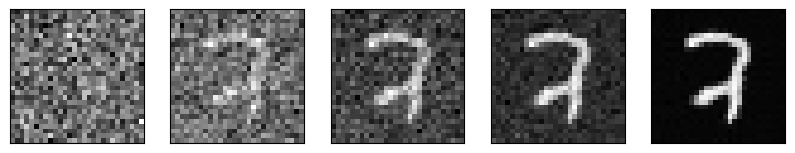

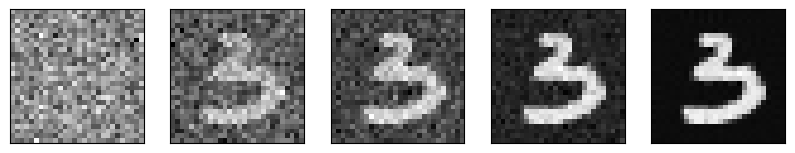

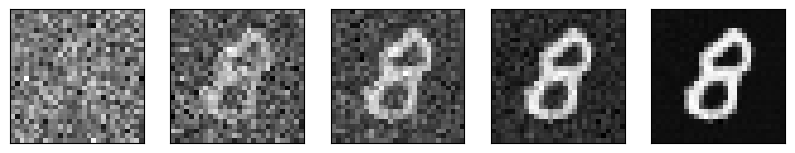

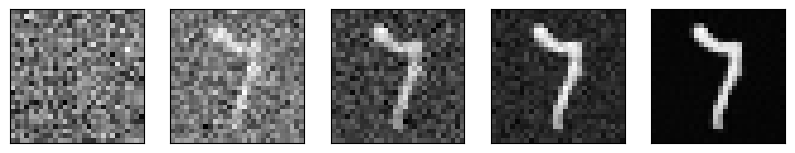

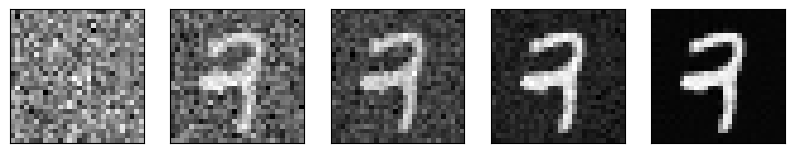

In [ ]:
test();